In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
# import subprocess
import pandas as pd
import mdtraj as mdt
from pathlib import Path
import matplotlib.pyplot as plt
import re


import sys
sys.path.append("../../analysis")
from chem_shift import compute_chem_shift


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [73]:
# traj = mdt.load("/data/gzappavigna/lmp_conf_builder/gmx/amber/step5_production_nojump.xtc", top="/data/gzappavigna/lmp_conf_builder/gmx/amber/step5_production_nojump.pdb")

xtc = "/data/gzappavigna/traj/a99sb-ildn_opc/step5_production_nojump.xtc"
pdb = "/data/gzappavigna/traj/a99sb-ildn_opc/step5_production_nojump.pdb"

tot_frames = 900 * 1e3 / 0.5
n_frames = 300 * 1e3 / 0.5

# traj = next(mdt.iterload(xtc, top=pdb, chunk=n_frames, skip=tot_frames-n_frames))
traj = next(mdt.iterload(xtc, top=pdb, chunk=n_frames, skip=0))

# traj = mdt.load(xtc, top=pdb, stride=3)
# traj = mdt.load(xtc, top=pdb, stride=2)

In [42]:
traj.time[-1] / 1e3

899.9995

In [74]:
df = compute_chem_shift(traj, period=100)

In [75]:
ca_cs = df.loc[(slice(None), 'CA'), :]

mu = ca_cs.mean(axis="columns")
sigma = ca_cs.std(axis="columns")

In [76]:
ca_cs

,frame,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
resSeq,name,,,,,,,,,,,,,,,,,,,,,
1,CA,55.344,55.335,55.399,55.275,55.374,55.349,55.312,55.344,55.322,55.352,...,55.395,55.155,55.332,55.352,55.351,55.267,55.339,55.360,55.351,55.358
2,CA,56.196,55.788,54.663,54.572,54.289,55.500,54.544,55.636,54.980,55.477,...,54.884,55.315,54.776,56.114,55.279,55.339,54.289,54.677,56.009,55.816
3,CA,55.433,55.071,56.185,56.800,56.925,57.421,57.385,56.684,56.096,57.124,...,56.178,55.506,56.370,55.868,56.595,55.459,57.397,56.325,57.382,55.684
4,CA,54.987,55.703,54.773,53.011,54.603,55.266,54.745,55.556,56.402,55.797,...,52.420,55.294,54.850,54.460,54.654,53.322,54.516,55.188,54.943,55.437
5,CA,54.440,54.308,54.398,58.878,55.166,54.955,54.347,54.208,56.188,54.741,...,59.279,54.393,55.108,56.640,55.028,57.107,55.083,53.925,55.201,54.753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,CA,55.288,55.022,55.772,55.730,55.910,55.555,55.709,55.593,55.449,55.660,...,55.591,56.163,55.890,56.105,55.662,55.154,55.431,55.510,55.455,54.690
129,CA,54.561,54.452,54.605,54.460,54.380,54.508,54.478,54.070,54.611,54.969,...,54.905,52.986,54.850,52.476,54.560,54.422,54.524,54.328,54.577,53.856
130,CA,56.038,55.980,56.325,55.983,56.061,56.010,55.880,56.001,56.495,55.890,...,55.906,55.435,55.957,54.963,56.477,56.514,56.897,56.225,56.596,55.525


In [77]:
mu = mu.reset_index()
new_index = mu.resSeq - 1
mu = mu.drop(columns=["name", "resSeq"])
mu = mu.set_index(new_index).squeeze()


In [78]:
atom_name = "(?:CA)|(?:CO)|N|(?:HN)"
pattern = rf"^(\d{{1,3}})([A-Z]?)({atom_name})-(\d{{1,3}})([A-Z]?)({atom_name})-({atom_name})$"

exp = pd.read_csv("lists_Ntail/Ntail_HNCOCA.list", sep=" ", header=None)
# exp = pd.read_csv("lists_Ntail/Ntail_HNCA.list", sep=" ", header=None)
seq_cs = "".join(exp[0].str.extract(pattern)[1])


In [79]:
exp[0]

0      401CA-402TN-HN
1      402CA-403EN-HN
2      403CA-404DN-HN
3      404CA-405KN-HN
4      405CA-406IN-HN
            ...      
108    520CA-521RN-HN
109     521CA-522N-HN
110    522CA-523LN-HN
111    523CA-524LN-HN
112    524CA-525DN-HN
Name: 0, Length: 113, dtype: object

In [80]:
exp

,0,1,2,3
0,401CA-402TN-HN,61.768,116.006,8.227
1,402CA-403EN-HN,62.120,122.950,8.437
2,403CA-404DN-HN,56.830,121.548,8.326
3,404CA-405KN-HN,54.571,121.138,8.209
4,405CA-406IN-HN,56.659,121.142,8.048
...,...,...,...,...
108,520CA-521RN-HN,54.411,120.790,8.183
109,521CA-522N-HN,56.330,119.179,8.440
110,522CA-523LN-HN,53.522,121.904,8.079
111,523CA-524LN-HN,55.327,122.212,8.089


In [81]:
info = exp[0].str.extract(pattern)
info

,0,1,2,3,4,5,6
0,401,,CA,402,T,N,HN
1,402,,CA,403,E,N,HN
2,403,,CA,404,D,N,HN
3,404,,CA,405,K,N,HN
4,405,,CA,406,I,N,HN
...,...,...,...,...,...,...,...
108,520,,CA,521,R,N,HN
109,521,,CA,522,,N,HN
110,522,,CA,523,L,N,HN
111,523,,CA,524,L,N,HN


In [82]:
top = traj.topology
residues = list(top.residues)

exp_idx2cs = {idx - 525 + len(residues) - 1: cs for idx, cs  in zip(info[0].astype(int), exp[1])}
# idx2cs = {idx: cs for idx, cs  in zip(info[0].astype(int), exp[1])}
exp_idx2cs



{7: 61.768,
 8: 62.12,
 9: 56.83,
 10: 54.571,
 11: 56.659,
 12: 61.339,
 13: 58.491,
 14: 55.956,
 15: 52.475,
 16: 62.059,
 18: 63.207,
 19: 56.371,
 20: 55.875,
 21: 52.615,
 22: 55.83,
 23: 62.313,
 24: 58.077,
 25: 57.59,
 26: 55.162,
 27: 56.017,
 28: 45.392,
 29: 54.408,
 30: 55.996,
 31: 59.004,
 32: 57.005,
 33: 53.429,
 34: 56.231,
 36: 63.174,
 37: 55.94,
 38: 55.152,
 39: 45.372,
 41: 56.65,
 42: 56.716,
 43: 54.34,
 44: 56.4,
 45: 56.754,
 46: 62.603,
 50: 56.507,
 51: 45.346,
 52: 56.449,
 53: 52.592,
 54: 56.246,
 55: 56.837,
 56: 58.465,
 57: 58.121,
 58: 55.808,
 59: 56.611,
 60: 61.674,
 62: 63.204,
 63: 58.416,
 64: 55.914,
 65: 52.953,
 66: 58.726,
 67: 54.338,
 68: 53.044,
 69: 56.376,
 70: 52.529,
 71: 52.609,
 72: 55.579,
 74: 63.2,
 75: 61.994,
 76: 45.176,
 78: 63.28,
 79: 55.17,
 80: 54.248,
 81: 61.208,
 82: 54.425,
 83: 62.222,
 84: 52.911,
 85: 58.61,
 86: 56.908,
 87: 58.427,
 88: 58.463,
 89: 55.545,
 91: 63.809,
 92: 56.354,
 93: 54.879,
 94: 59.469,
 95

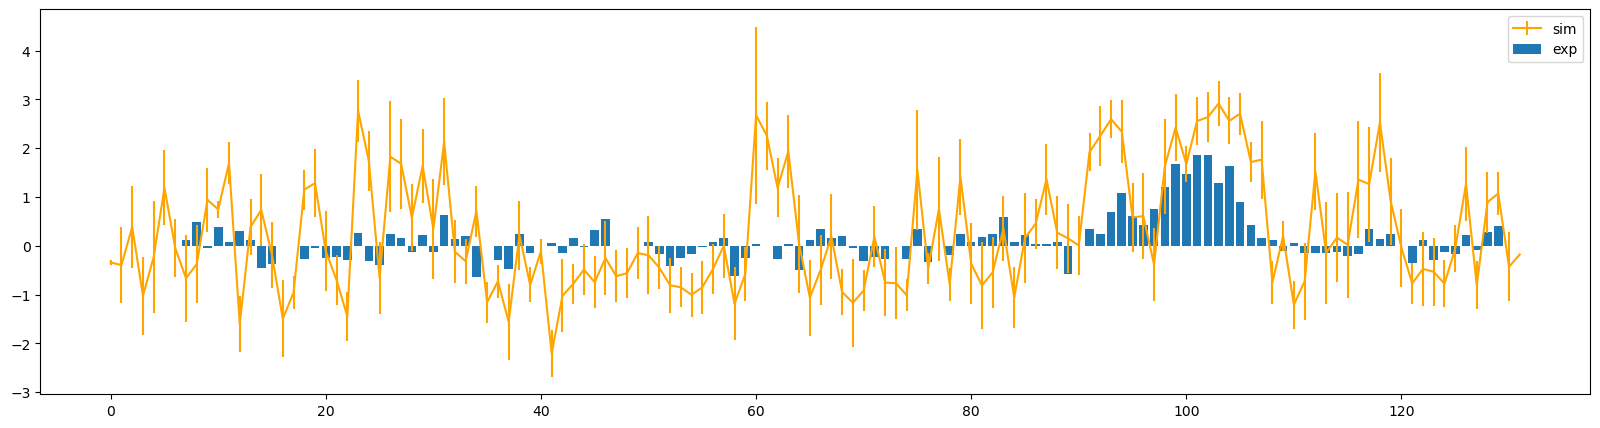

In [84]:
from chem_shift import compute_secondary_cs


plt.figure(figsize=(20, 5))

sim_idx2scs = compute_secondary_cs(residues, mu.to_dict())

indx, scs = np.array(list(sim_idx2scs.keys())), np.array(list(sim_idx2scs.values()))
# plt.bar(indx, scs, label="sim") # color='orange')
plt.errorbar(indx, scs, sigma.to_list(), label="sim", color='orange')

exp_idx2scs = compute_secondary_cs(residues, exp_idx2cs)

indx, scs = np.array(list(exp_idx2scs.keys())), np.array(list(exp_idx2scs.values()))
plt.bar(indx, scs, label="exp")

plt.legend()


In [16]:
orig_inds = exp[0].str.extract(pattern)[0].astype(int).to_numpy()
orig_inds = orig_inds - orig_inds[0] + 7
orig_inds

array([  7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  36,  37,  38,  39,  41,  42,  43,  44,  45,  46,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  74,  75,  76,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130])

In [37]:
delta_sim = np.diff(inds_sim)
delta_sim


array([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1])

In [61]:
from Bio import SeqIO
res = SeqIO.parse("/data/gzappavigna/traj/a99sb-ildn_opc/step5_production_nojump.pdb", "pdb-atom")
seq_sim = str(list(res)[0].seq)

/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=H1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=H2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=H3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (na

In [62]:
from Bio import Align

aligner = Align.PairwiseAligner()

alignments = aligner.align(seq_sim, seq_cs)
alignment = alignments[0]
print(alignment)

ValueError: sequence has zero length

In [19]:
inds = alignment.indices

inds_sim, inds_exp = inds[:, np.all(inds != -1, axis=0)]

NameError: name 'alignment' is not defined

In [33]:
np.diff(inds_sim)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
exp[1].iloc[inds_exp[:-1]].size

109

In [15]:
mu.loc[inds_sim[:-1]].size

109

In [21]:
exp

,0,1,2,3
0,401CA-402TN-HN,61.768,116.006,8.227
1,402CA-403EN-HN,62.120,122.950,8.437
2,403CA-404DN-HN,56.830,121.548,8.326
3,404CA-405KN-HN,54.571,121.138,8.209
4,405CA-406IN-HN,56.659,121.142,8.048
...,...,...,...,...
108,520CA-521RN-HN,54.411,120.790,8.183
109,521CA-522N-HN,56.330,119.179,8.440
110,522CA-523LN-HN,53.522,121.904,8.079
111,523CA-524LN-HN,55.327,122.212,8.089


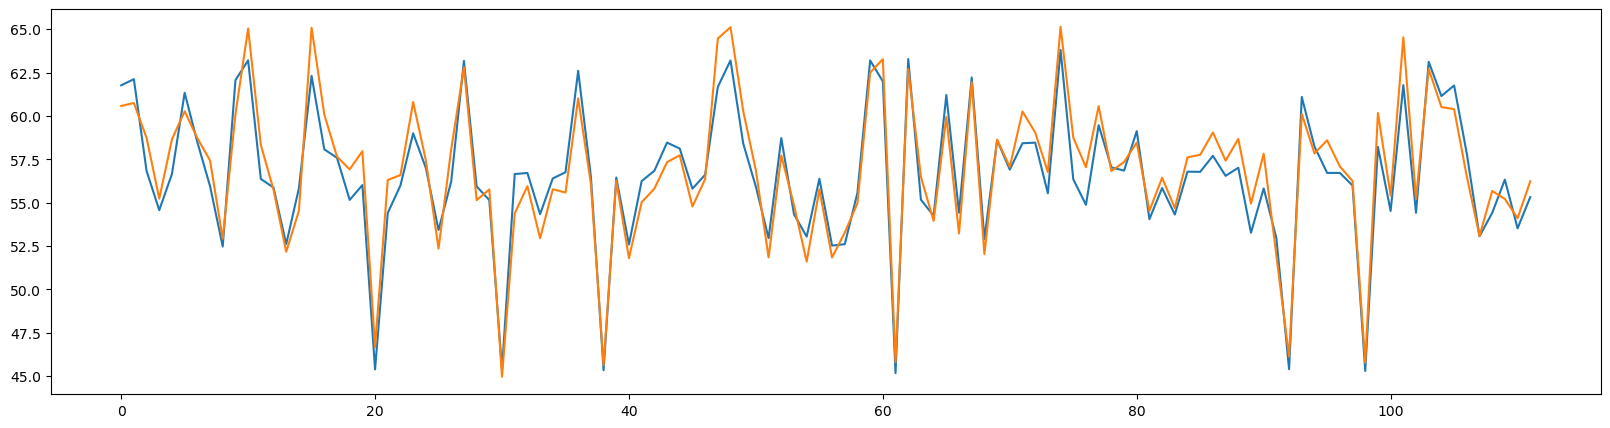

In [85]:
plt.figure(figsize=(20, 5))

# plt.plot(exp[1].loc[inds_exp[:-1]].to_numpy())
plt.plot(exp[1][:-1].to_numpy())
# plt.plot(mu.loc[inds_sim[:-1]].to_numpy())
plt.plot(mu.loc[orig_inds[:-1]].to_numpy())

In [51]:
inds_exp[0]

0

In [ ]:
from MDAnalysis.lib.util import convert_aa_code
from parse import parse

exp = pd.read_csv("secondary_cs_temp/ntail_25c_ca.scs", sep=" ", header=None, names=["residue", "diff", "cs", "rc_cs"])
"".join(exp.residue.apply(lambda x: convert_aa_code(list(parse("{:3d}{:3}", x))[1])).to_numpy())


In [ ]:

plt.figure(figsize=(20, 5))
# plt.errorbar(x=np.arange(mu.size), y=mu, yerr=sigma)
plt.bar(np.arange(mu.size), mu - exp.rc_cs)